## Graph Convolutional Networks

グラフ畳み込みネットワーク(GCN)についてまとめる。


### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/graph/01/01_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/graph/01/01_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:		macOS
ProductVersion:		13.5.1
BuildVersion:		22G90


In [2]:
!python -V

Python 3.9.12


$$\int_a^b f(x) dx = \infty$$

$$E = \sum_{(u_i, d_j, r_{ij}) \in T}{e_{ij}} = \sum_{(u_i,d_j,r_{ij}) \in T}{(r_{ij} - \sum_{k=1}^K{p_{ik}q_{kj}})^2}$$

基本的なライブラリをインポートしそのバージョンを確認しておきます。
学習をpytorchを利用し、ネットワーク関係はnetworkxを利用する。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from tabulate import tabulate

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib

print('matplotlib  : {}'.format(matplotlib.__version__))
print('networkdx   : {}'.format(nx.__version__))
print('numpy       : {}'.format(np.__version__))
print('torch       : {}'.format(torch.__version__))

matplotlib  : 3.5.1
networkdx   : 2.7.1
numpy       : 1.22.3
torch       : 1.12.0


In [2]:
import scipy

scipy.__version__

'1.8.1'

In [3]:
!which python

/Users/83005814_mac/anaconda3/bin/python


In [4]:
import sys

sys.executable

'/Users/83005814_mac/anaconda3/envs/rec/bin/python'

## 二部グラフの作成、L、A、D、正規化行列の計算

わかりやすく、小さなグラフで作成する

$$
R_{u, i}=\left\lbrace\begin{array}{lr}
1, & \text { if }(u, i) \text { interaction is observed } \\
0, & \text { otherwise }
\end{array}\right.
$$


$$
\begin{array}{|l|r|r|r|r|}
\hline & \text{ item1 } & \text{ item2 } & \text{ item3 } & \text{ item4 } \\
\hline \text{ user1 } & 0 & 1 & 0 & 0 \\
\hline \text{ user2 } & 0 & 0 & 1 & 1 \\
\hline \text{ user3 } & 1 & 0 & 0 & 0 \\
\hline \text{ user4 } & 0 & 1 & 0 & 0 \\
\hline \text{ user5 } & 1 & 0 & 1 & 0 \\
\hline
\end{array}
$$

In [2]:
np.random.seed(seed=16)
np.set_printoptions(threshold=10000000)

B = nx.Graph()

user_num = 3
item_num = 4

user_nodes = [i for i in range(user_num)]
item_nodes = [i for i in range(100, 100 + item_num)]

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)

node_color = []
node_size = [600 for i in range(user_num + item_num)]

for u in user_nodes:
    node_color.append("red")
for i in item_nodes:
    node_color.append("lightblue")

edge_nodes = []
pos = {}
for _i, u in enumerate(user_nodes):
    pos[u] = np.array([-1, -1.75 * _i])
    for _j, i in enumerate(item_nodes):
        pos[i] = np.array([1, -1.75 * _j])
        if np.random.random() < 0.45:
            edge_nodes.append((u, i))

B.add_edges_from(edge_nodes)

nx.draw(B, pos=pos, with_labels=True, node_color=node_color, node_size=node_size)

plt.show()

NameError: name 'np' is not defined

In [6]:
edge_nodes

[(0, 100), (0, 103), (1, 100), (1, 101), (1, 103), (2, 100), (2, 103)]

In [7]:
dir(nx.adjacency_matrix(B))
print(nx.adjacency_matrix(B))

  (0, 3)	1
  (0, 6)	1
  (1, 3)	1
  (1, 4)	1
  (1, 6)	1
  (2, 3)	1
  (2, 6)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (4, 1)	1
  (6, 0)	1
  (6, 1)	1
  (6, 2)	1


/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_19788/4100402902.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  dir(nx.adjacency_matrix(B))
/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_19788/4100402902.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(B))


In [10]:
A = np.array(nx.adjacency_matrix(B).todense())
L = np.array(nx.laplacian_matrix(B).todense())
D = L + A
A

/var/folders/hf/n122ckrx1s7d_4znx12t3r800000gq/T/ipykernel_19788/2610973267.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(B).todense())


array([[0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0]])

上の二部グラフを嗜好行列で表すと以下のようになります。

|  | item_100 | item_200 | item_300 | item_400 |
| :---: | :---: | :---: | :---: | :---: |
| user_0 | 1 | 0 | 0 | 1 |
| user_1 | 1 | 1 | 0 | 1 |
| user_2 | 1 | 0 | 0 | 1 |

networkx型のオブジェクトから、嗜好行列や隣接行列を作ることができます。

In [11]:
D = L + A
A

array([[0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0]])

In [8]:
R = A[0:user_num, user_num:]
R

array([[1, 0, 0, 1],
       [1, 1, 0, 1],
       [1, 0, 0, 1]])

In [9]:
D_I = np.sum(R, axis=0)
D_I

array([3, 1, 0, 3])

In [56]:
D_U = np.sum(R, axis=1)
D_U

array([2, 3, 2], dtype=int64)

In [57]:
R_hat = np.diag(np.power(D_U + 1e-15, -1 / 2)) @ R @ np.diag(np.power(D_I + 1e-15, -1 / 2))
R_hat.round(2)

array([[0.41, 0.  , 0.  , 0.41],
       [0.33, 0.58, 0.  , 0.33],
       [0.41, 0.  , 0.  , 0.41]])

In [58]:
A_hat = np.block([[A[:user_num, :user_num], R_hat], [R_hat.T, A[user_num:, user_num:]]])
A_hat.round(2)

array([[0.  , 0.  , 0.  , 0.41, 0.  , 0.  , 0.41],
       [0.  , 0.  , 0.  , 0.33, 0.58, 0.  , 0.33],
       [0.  , 0.  , 0.  , 0.41, 0.  , 0.  , 0.41],
       [0.41, 0.33, 0.41, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.41, 0.33, 0.41, 0.  , 0.  , 0.  , 0.  ]])

In [59]:
# user-user 正規化隣接行列
P_item_hat = R_hat @ R_hat.T
P_item_hat.round(2)

array([[0.33, 0.27, 0.33],
       [0.27, 0.56, 0.27],
       [0.33, 0.27, 0.33]])

In [60]:
# item-item 正規化隣接行列
P_user_hat = R_hat.T @ R_hat
P_user_hat.round(2)

array([[0.44, 0.19, 0.  , 0.44],
       [0.19, 0.33, 0.  , 0.19],
       [0.  , 0.  , 0.  , 0.  ],
       [0.44, 0.19, 0.  , 0.44]])

In [61]:
n_users = 3
n_items = 4
embedding_size = 64

user_embedding = nn.Embedding(n_users, embedding_size)
item_embedding = nn.Embedding(n_items, embedding_size)

In [62]:
user_embedding

Embedding(3, 64)

In [63]:
item_embedding

Embedding(4, 64)

In [64]:
def forward(X, A_hat):
    H = torch.mm(torch.mm(A_hat, X), self.W_0)
    H = F.relu(H)
    H = torch.mm(torch.mm(A_hat, H), self.W_1)
    return F.log_softmax(H, dim=1)

In [65]:
class GCN(nn.Module):
    def __init__(self, A_hat, num_feat, num_hidden, num_class):
        super(GCN, self).__init__()
        self.num_feat = num_feat
        self.num_hidden = num_hidden
        self.num_class = num_class
        self.A_hat = A_hat
        self.W_0 = nn.Parameter(torch.Tensor(num_feat, num_hidden))
        self.W_1 = nn.Parameter(torch.Tensor(num_hidden, num_class))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.W_0.size(1))
        self.W_0.data.uniform_(-stdv, stdv)
        stdv = 1.0 / math.sqrt(self.W_1.size(1))
        self.W_1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        H = torch.mm(torch.mm(A_hat, X), self.W_0)
        H = F.relu(H)
        H = torch.mm(torch.mm(A_hat, H), self.W_1)
        return F.log_softmax(H, dim=1)

pytorchの場合は

## Graph Convolutional Networks 

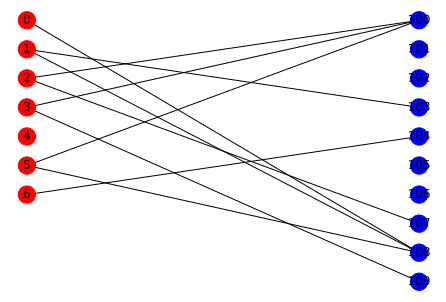

In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(threshold=10000000)

B = nx.Graph()

user_num = 7
item_num = 10

user_nodes = [i for i in range(user_num)]
item_nodes = [i for i in range(100, 100 + item_num)]

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)

node_color = []

for u in user_nodes:
    node_color.append("red")
for i in item_nodes:
    node_color.append("blue")

edge_nodes = []
pos = {}
for _i, u in enumerate(user_nodes):
    pos[u] = np.array([-1, -1.75 * _i])
    for _j, i in enumerate(item_nodes):
        pos[i] = np.array([1, -1.75 * _j])
        if np.random.random() < 0.15:
            edge_nodes.append((u, i))

B.add_edges_from(edge_nodes)

nx.draw(B, pos=pos, with_labels=True, node_color=node_color)

plt.show()

In [67]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()

print(loss)

# 入力のサイズはN x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)

print(input)
# ターゲットの各要素は0 <=値<Cである必要があります
target = torch.tensor([1, 0, 4])
print(target)
output = loss(m(input), target)
print(output)
output.backward()

NLLLoss()
tensor([[-2.1383, -0.6961, -1.1747,  2.1168, -1.4791],
        [ 1.8073,  1.5682,  0.5385,  1.5459, -0.0277],
        [ 1.3852, -1.1378,  0.1540, -0.5693,  1.8205]], requires_grad=True)
tensor([1, 0, 4])
tensor(1.5746, grad_fn=<NllLossBackward0>)


レコメンドにおけるグラフは、通常2部グラフとして表現されます。

$$
\tilde{R}=D_{U}^{-\frac{1}{2}} R D_{I}^{-\frac{1}{2}}
$$

networkxにはグラフラプラシアン$L$を求める関数が酔いされています。
$$
L=D-A
$$

次数行列は以下の様に求める事が出来ます。

$$
D = L + A
$$

## グラフラプラシアンの正規化

$$
\tilde{L}=I-\tilde{A}
$$

$$
\Delta f=\frac{\partial^{2} f}{\partial x^{2}}+\frac{\partial^{2} f}{\partial y^{2}}+\frac{\partial^{2} f}{\partial z^{2}}
$$

$$
\Delta h_{\omega}(x)=\lambda_{\omega} h_{\omega}(x)
$$

$$
h_{\omega}(x)=e^{i \omega x}
$$

$$
g(t) * f(t)=\sum_{\tau} g(\tau) f(t-\tau)
$$

$$
F[g(t) * f(t)]=F[g(t)] F[f(t)]
$$

$$
\begin{gathered}
\hat{\mathbf{x}}=\mathbf{U}^{T} \mathbf{x} \\
\mathbf{x}=\mathbf{U} \widehat{\mathbf{x}}
\end{gathered}
$$

$$
\mathcal{H}(\boldsymbol{L})=\operatorname{UDiag}\left(h\left(\lambda_{1}\right), \cdots, h\left(\lambda_{n}\right)\right) U^{T}
$$

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset

from SVDppRecommender import SVDpp


class RateDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)


data = {
    (0, 0): 4,
    (0, 1): 5,
    (0, 2): 3,
    (0, 3): 4,
    (1, 0): 5,
    (1, 1): 3,
    (1, 2): 4,
    (1, 3): 1,
    (2, 0): 3,
    (2, 1): 2,
    (2, 2): 5,
    (2, 3): 5,
    (3, 0): 4,
    (3, 1): 2,
    (3, 2): 3,
    (3, 3): 1,
}
Iu = {key: [0, 1, 2, 3] for key in range(4)}

user_tensor = torch.LongTensor([key[0] for key in data.keys()])
item_tensor = torch.LongTensor([key[1] for key in data.keys()])
rating_tensor = torch.FloatTensor([val for val in data.values()])

params = {"num_users": 4, "num_items": 4, "global_mean": 3, "latent_dim": 10}

model = SVDpp(params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataset = RateDataset(user_tensor, item_tensor, rating_tensor)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

for epoch in range(30):
    for bid, batch in enumerate(train_loader):
        u, i, r = batch[0], batch[1], batch[2]
        r = r.float()
        # forward pass
        preds = model(u, i, Iu)
        loss = criterion(preds, r)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch [{}/30], Loss: {:.4f}".format(epoch + 1, loss.item()))

ModuleNotFoundError: No module named 'SVDppRecommender'

In [ ]:
import numpy as np

X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF

model = NMF(n_components=2, init="random", random_state=0)
W = model.fit_transform(A_hat)
H = model.components_

In [70]:
X

array([[1. , 1. ],
       [2. , 1. ],
       [3. , 1.2],
       [4. , 1. ],
       [5. , 0.8],
       [6. , 1. ]])

In [71]:
W

array([[1.55391099e-11, 3.40767530e-01],
       [0.00000000e+00, 4.17373793e-01],
       [1.55391099e-11, 3.40767530e-01],
       [5.83954597e-01, 0.00000000e+00],
       [3.37146309e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [5.83954597e-01, 0.00000000e+00]])

In [72]:
H

array([[5.99236855e-01, 7.33912241e-01, 5.99236855e-01, 2.27854326e-12,
        0.00000000e+00, 0.00000000e+00, 2.27854326e-12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.02685282e+00,
        5.92873174e-01, 0.00000000e+00, 1.02685282e+00]])

In [73]:
np.dot(W, H).round(2)

array([[0.  , 0.  , 0.  , 0.35, 0.2 , 0.  , 0.35],
       [0.  , 0.  , 0.  , 0.43, 0.25, 0.  , 0.43],
       [0.  , 0.  , 0.  , 0.35, 0.2 , 0.  , 0.35],
       [0.35, 0.43, 0.35, 0.  , 0.  , 0.  , 0.  ],
       [0.2 , 0.25, 0.2 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.35, 0.43, 0.35, 0.  , 0.  , 0.  , 0.  ]])

In [2]:
a = "test"